In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

from sklearn.decomposition import PCA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

In [22]:
dfAbnormal1 = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal1 = pd.read_csv("../cleanData/clean_normal.csv")
dfAbnormal = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal = pd.read_csv("../cleanData/clean_normal.csv")


dfAbnormal_1 = pd.concat([dfAbnormal, dfAbnormal1], ignore_index=True)
dfnormal_1 = pd.concat([dfnormal, dfnormal1], ignore_index=True)

In [39]:
# Define number of top features to select
k = 7  # Adjust this value as needed

# Combine datasets and add label columns
dfAbnormal_1['Label'] = 1
dfnormal_1['Label'] = 0
df_combined = pd.concat([dfAbnormal_1, dfnormal_1], ignore_index=True)

# Separate features and target
X = df_combined.drop(columns='Label')
y = df_combined['Label']

# Apply SelectKBest with f_regression
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support(indices=True)]
print(f'Selected top {k} features using SelectKBest with f_regression:')
for feature in selected_features:
    print(feature)

# Create a new dataframe with selected features and labels
df_selected = pd.DataFrame(X_new, columns=selected_features)
df_selected['Label'] = y.values


Selected top 7 features using SelectKBest with f_regression:
CONDUCTIVITY
TEMP
MIN_BLOOD
PULSE
SYRINGE_FLOW
TARGET_UF
BREATH


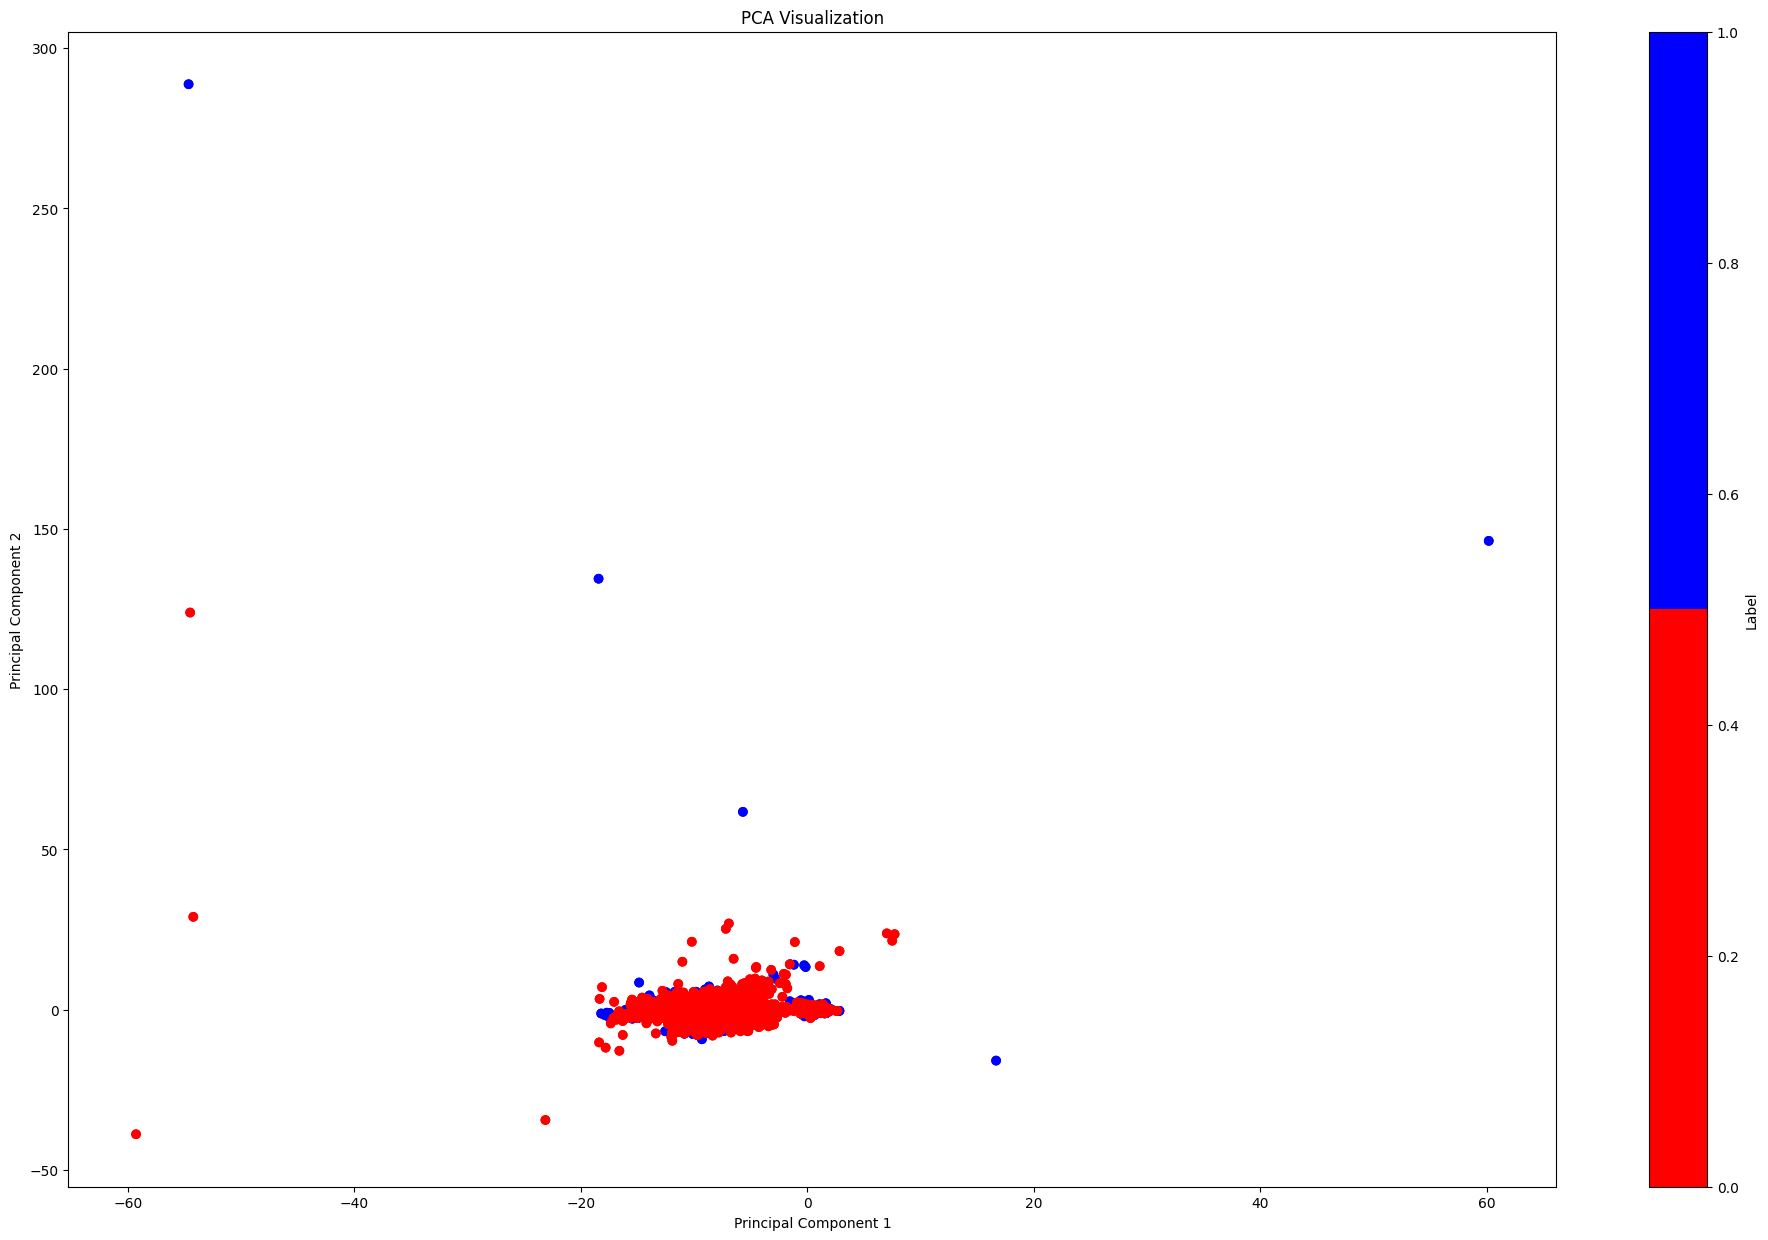

In [24]:
# Combine datasets and add label columns
dfAbnormal_1['Label'] = 1
dfnormal_1['Label'] = 0
df_combined = pd.concat([dfAbnormal_1, dfnormal_1], ignore_index=True)

# Separate features and target
X = df_combined.drop(columns='Label')
y = df_combined['Label']

# Standardize the data
X_standardized = StandardScaler().fit_transform(X)

# Apply PCA
n_components = 2  # Number of principal components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

# Create a new dataframe with PCA results
df_pca = pd.DataFrame(X_pca, columns=[f'Principal Component {i+1}' for i in range(n_components)])
df_pca['Label'] = y.values

# Plot PCA results
plt.figure(figsize=(24, 15))
scatter = plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], c=df_pca['Label'], cmap=ListedColormap(['red', 'blue']))
plt.title('PCA Visualization')
plt.colorbar(scatter, label='Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [25]:
df_pca

,Principal Component 1,Principal Component 2,Label
0,0.246531,0.368421,1
1,0.152543,0.506871,1
2,0.117203,0.194460,1
3,0.126307,0.536517,1
4,0.132909,0.229465,1
...,...,...,...
207673,0.350576,-0.044426,0
207674,0.470194,-0.066573,0
207675,0.451695,-0.005415,0
207676,0.454837,-0.157799,0


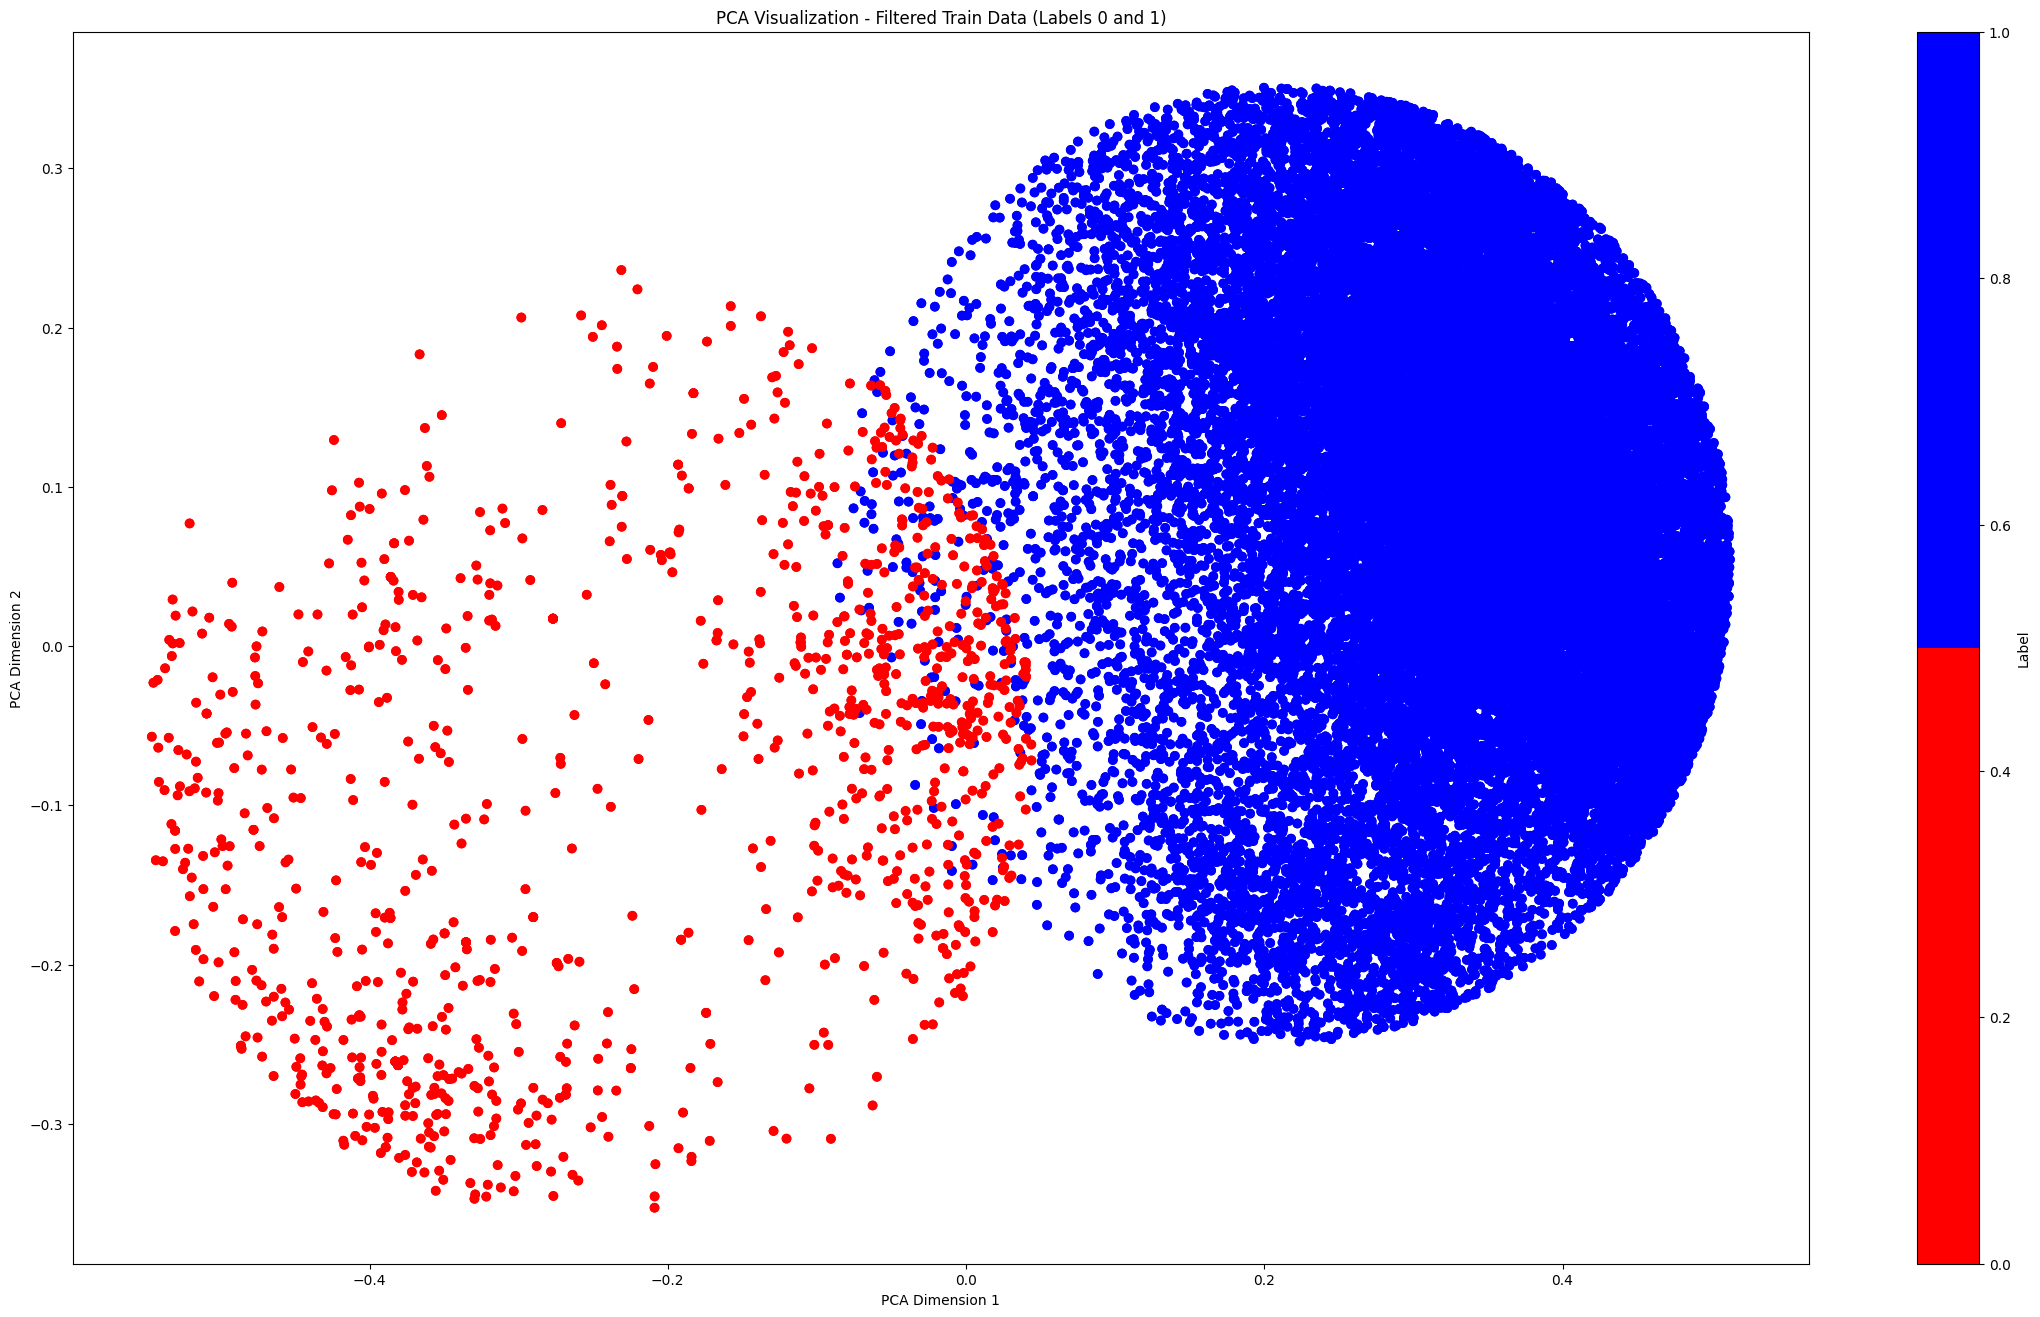

In [32]:
# 创建一个新的DataFrame包含t-SNE结果
df_pca = pd.DataFrame(X_pca, columns=[f'Principal Component {i+1}' for i in range(n_components)])
df_pca['Label'] = y.values

# 将数据分为训练和测试集 (这里需要您具体的训练和测试集划分逻辑)
train_tsne_embedded = df_pca[['Principal Component 1', 'Principal Component 2']].values  # 替换为实际的训练集嵌入结果
train_labels = df_pca['Label'].values  # 替换为实际的训练集标签
# 计算类别的中心点
def compute_class_centers(points, labels):
    unique_labels = np.unique(labels)
    centers = {}
    for label in unique_labels:
        centers[label] = np.mean(points[labels == label], axis=0)
    return centers

# 定义阈值来过滤数据
distance_threshold = 0.3  # 这是一个示例阈值，请根据实际情况调整

# 筛选标签为0和1的训练数据点
train_mask = np.isin(train_labels, [0, 1])
train_tsne_embedded_01 = train_tsne_embedded[train_mask]
train_labels_01 = train_labels[train_mask]

# 计算训练数据的类别中心
train_class_centers = compute_class_centers(train_tsne_embedded_01, train_labels_01)

# 过滤训练数据
filtered_train_points = []
filtered_train_labels = []
for i, point in enumerate(train_tsne_embedded_01):
    label = train_labels_01[i]
    center = train_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_train_points.append(point)
        filtered_train_labels.append(label)

filtered_train_points = np.array(filtered_train_points)


# 可视化过滤后的训练数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_train_points[:, 0], filtered_train_points[:, 1], c=filtered_train_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('PCA Visualization - Filtered Train Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()


In [33]:
# 创建一个哈希表，以加快查找速度
point_to_index = {tuple(point): index for index, point in enumerate(train_tsne_embedded)}

# 使用哈希表查找每个点的索引
indices = np.array([point_to_index[tuple(point)] for point in filtered_train_points])

selected_rows = df_selected.iloc[indices]

df_final = pd.DataFrame(selected_rows)

In [34]:
df_final

,CONDUCTIVITY,TEMP,MIN_BLOOD,PULSE,SYRINGE_FLOW,TARGET_UF,BREATH,Label
2,14.1,36.0,72.0,77.0,3.062776,4.0,15.852175,1
4,14.2,36.0,66.0,84.0,3.062776,4.0,15.852175,1
5,14.2,36.0,66.0,84.0,3.062776,2.9,15.852175,1
6,14.2,36.0,66.0,84.0,3.062776,2.9,15.852175,1
8,14.2,36.1,59.0,83.0,3.062776,2.9,15.852175,1
...,...,...,...,...,...,...,...,...
207403,9.8,36.5,73.0,81.0,2.957738,2.4,15.482281,0
207459,13.8,36.9,69.0,68.0,2.957738,2.8,15.482281,0
207460,13.8,36.9,69.0,68.0,2.957738,2.8,15.482281,0
207461,13.8,36.7,71.0,75.0,2.957738,2.8,15.000000,0


In [35]:
df_final.to_csv("../cnnData/PCA.csv")